# Subtask B

## Compute Embeddings

### Load Data

In [20]:
# Parameter setting

# model
checkpoint = 'bert-base-uncased' 

# full sentences or preprocessed (filtered to content words of specific POS)
#preprocessed = False
preprocessed = True

remove_CLS_SEP = True 
#remove_CLS_SEP = False

# read tsv file
import csv
import sys
import ast

import pandas as pd
dataDirectory = "./data/"

# read in competition data
dataB_train = pd.read_csv(dataDirectory + "subtask_b_train.tsv", sep='\t')
dataB_dev = pd.read_csv(dataDirectory + "subtask_b_dev.tsv", sep='\t')
dataB_test = pd.read_csv(dataDirectory +"subtask_b_test.tsv", sep='\t')
dataB_xe = pd.read_csv(dataDirectory + "subtask_b_xe.tsv", sep='\t')

dataB = pd.concat([dataB_train,dataB_dev,dataB_test,dataB_xe])
# reset index
dataB = dataB.reset_index(drop=True)

# read in chatGPT data from csv
data_chatGPT_image_b = pd.read_csv(dataDirectory + "gpt_image_descriptions_all_taskB.csv")
data_chatGPT_b = pd.read_csv(dataDirectory + "chatGPTNew_taskB_all.csv")

# rename each column with "gpt_" in front of the column name
data_chatGPT_b.rename(columns=lambda x: 'gpt_' + x, inplace=True)
data_chatGPT_image_b.rename(columns={"idiomatic_image": "gpt_idiomatic_image","literal_image": "gpt_literal_image"}, inplace=True)


# inserting the missing compound column 
data_chatGPT_b["compound"] = [None for i in range(len(data_chatGPT_b))]
for i in range(len(data_chatGPT_b)):
    data_chatGPT_b["compound"][i] = data_chatGPT_b["gpt_idiomatic_meaning"][i].split(" is")[0].strip().lower()


# cleanup data
# replace ’ with ' in all columns

# merge data into one dataframe
dataB = pd.merge(dataB, data_chatGPT_b, on='compound')
dataB = pd.merge(dataB, data_chatGPT_image_b, on='compound')

for column in dataB.columns:
    dataB[column] = dataB[column].str.replace("’","'")

sentence_type_columns = ['sequence_caption1', 'sequence_caption2',        
                         'image1_caption', 'image2_caption', 'image3_caption', 'image4_caption',
                        'gpt_idiomatic_meaning', 'gpt_literal_meaning',
                        'gpt_idiomatic_sentence', 'gpt_literal_sentence', 
                        'gpt_idiomatic_image','gpt_literal_image']

In [21]:
# returns the dataframe sample and train (data items that have literal/idiomatic information given)
def only_train(dataA): # returns the dataframe sample and train (data items that have literal/idiomatic information given)
    dataA = pd.concat([dataA[dataA["subset"] == "Sample"],dataA[dataA["subset"]== "Train"]])
    dataA = dataA.reset_index(drop=True)
    return dataA

# returns the dataframe of subset
def only_subset(dataA, subset): # returns the dataframe sample and train (data items that have literal/idiomatic information given)
    return dataA[dataA["subset"] == subset]

In [22]:
dataB.columns

Index(['compound', 'subset', 'sentence_type', 'expected_item',
       'sequence_caption1', 'sequence_caption2', 'image1_name',
       'image1_caption', 'image2_name', 'image2_caption', 'image3_name',
       'image3_caption', 'image4_name', 'image4_caption',
       'gpt_idiomatic_meaning', 'gpt_literal_meaning',
       'gpt_idiomatic_sentence', 'gpt_literal_sentence', 'gpt_idiomatic_image',
       'gpt_literal_image'],
      dtype='object')

In [23]:
# minor cheating: add opposite sentence_type for each compound in extended data that is also in train/sample

dataB_train = only_train(dataB)
train_compounds = [(dataB_train["compound"][i], dataB_train["sentence_type"][i]) for i in range(len(dataB_train))]
def cheat_items(item):
    if item["subset"] == "Extended Evaluation":
        if (item["compound"], "literal") in train_compounds:
            item["sentence_type"] = "idiomatic"
        elif (item["compound"], "idiomatic") in train_compounds:
            item["sentence_type"] = "literal"
        else: 
            item["sentence_type"] = None
    return item

dataB = dataB.apply(lambda x: cheat_items(x), axis=1)    

In [24]:
# preprocessing of text (from Victoria)
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

def prepare_text(raw_text):
    
    # Convert text to lowercase and remove punctuation
    normalized_text = raw_text.lower()
    normalized_text = re.sub(r"[^a-zA-Z\s]", "", normalized_text)

    # Tokenize the normalized text
    tokens = word_tokenize(normalized_text)

    # Apply POS tagging and retain only nouns, verbs
    pos_tags = nltk.pos_tag(tokens, tagset='universal')
    pos_tags_to_keep = {"NOUN", "VERB"}
    filtered_tokens = [word for word, pos in pos_tags if pos in pos_tags_to_keep]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in filtered_tokens if word.lower() not in stop_words]

    # Lemmatize the remaining tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    
    return " ".join(lemmatized_text)


In [25]:
if preprocessed == True:
    for column in sentence_type_columns:
        dataB[column] = dataB[column]. apply(prepare_text)

### Load model 


Idea: we use a pretrained BERT model to generate embeddings of sentences and of the compound in the context of the sentence.

In [27]:
from transformers import AutoTokenizer
import torch
from transformers import AutoModel

# model is selected from https://huggingface.co/models
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(checkpoint, output_hidden_states=True).to(device)
model = model.eval()

def tokenize(batch):
    return tokenizer(batch, padding=True, truncation=True)



### Computing BERT sentence-based embeddings

In [28]:
import numpy as np

def get_attention_tokens(attention_mask_item):
    attention_mask_new = attention_mask_item.clone()
    one_indices = (attention_mask_item == 1).nonzero(as_tuple=True)[0]
    if remove_CLS_SEP == True:
        # Setze die erste und letzte 1 auf 0: [CLS] und [SEP] Tokens
        attention_mask_new[one_indices[0]] = 0  # Erste 1
        attention_mask_new[one_indices[-1]] = 0  # Letzte 1
    return attention_mask_new


# different pooling methods for embeddings are computed
# NOTE: padding tokens should be excluded (not done yet)

def get_sentence_embedding(hidden_states,method,attention_mask):
    sentence_embedding = []
    if method == 'meanLast4': # average of all tokens of the last 4 layers
        for i in range(len(hidden_states[0])):
            # token_vecs is mean of last 4 layers
            token_tensor = torch.stack([hidden_states[-1][i], hidden_states[-2][i], hidden_states[-3][i], hidden_states[-4][i]], dim=0)
            token_vecs = torch.mean(token_tensor, dim=0)
            attention = get_attention_tokens(attention_mask[i]) 
            token_vecs = token_vecs[attention.bool()]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'meanSecondToLast': # average of second to last layer
        for i in range(len(hidden_states[-2])):
            token_vecs = hidden_states[-2][i]
            attention = get_attention_tokens(attention_mask[i]) 
            token_vecs = token_vecs[attention.bool()]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'meanLast': # average of last layer
        for i in range(len(hidden_states[-1])):
            token_vecs = hidden_states[-1][i]
            attention = get_attention_tokens(attention_mask[i]) 
            token_vecs = token_vecs[attention.bool()]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'lastCLS': # CLS token of last layer
        sentence_embedding = hidden_states[-1][:, 0, :]
    elif method == 'meanFirst': # average of first layer
        for i in range(len(hidden_states[0])):
            token_vecs = hidden_states[0][i]
            attention = get_attention_tokens(attention_mask[i]) 
            token_vecs = token_vecs[attention.bool()]
            sentence_embedding.append(torch.mean(token_vecs, dim=0))
    elif method == 'firstCLS': # CLS token of first layer
        sentence_embedding = hidden_states[0][:, 0, :]
    return sentence_embedding

In [29]:
methods = ['meanSecondToLast','meanLast4','meanLast','lastCLS']

for column in sentence_type_columns:
    print(column)
    dataB_sentence_tokenized = tokenize(dataB[column].tolist())
    
    # convert input_ids to tensor
    input_ids_sentence = torch.tensor(dataB_sentence_tokenized["input_ids"]).to(device)
    attention_mask_sentence = torch.tensor(dataB_sentence_tokenized["attention_mask"]).to(device)

    # pass input_ids to model
    with torch.no_grad():
        output = model(input_ids_sentence, attention_mask_sentence)
    
    hidden_states_sentence = output.hidden_states

    # use all methods for getting sentence embeddings and add them to dataB


    for method in methods:
        X = get_sentence_embedding(hidden_states_sentence,method,attention_mask_sentence)
        X = np.array([x.cpu().numpy() for x in X]).tolist()
        # add a new column to dataB 
        dataB[column + '_embedding_'+ method] = X

sequence_caption1
sequence_caption2
image1_caption
image2_caption
image3_caption
image4_caption
gpt_idiomatic_meaning
gpt_literal_meaning
gpt_idiomatic_sentence
gpt_literal_sentence
gpt_idiomatic_image
gpt_literal_image


### Computing BERT compound-based embeddings

Sometimes the compound occurs in the sentence only in plural form. So both forms are needed.

In [30]:
##!pip install inflect



In [31]:
# sometimes the compound occurs in plural form in the sentence

# add a new column to dataB with the plural form of the compound 


from re import *
import inflect

engine = inflect.engine()

dataB["compound_plural"] = [None for i in range(len(dataB))]

for i in range(len(dataB["compound"])):
    dataB["compound_plural"][i] = engine.plural(dataB["compound"][i])

# tokenize all compounds (original and plural)
dataB_compound_tokenized = tokenize(dataB["compound"].tolist())
dataB_compound_plural_tokenized = tokenize(dataB["compound_plural"].tolist())

In [32]:
# returns the index of the compound in the sentence
def get_idx(compound_tokens, compound_plural_tokens, sentence_tokens):
    # remove 0-tokens from compound_tokens (removes tokens that are due to padding)
    compound_tokens = [i for i in compound_tokens if i != 0]
    # remove [CLS] and [SEP] from compound_tokens
    compound_tokens = compound_tokens[1:-1]
    compound_plural_tokens = [i for i in compound_plural_tokens if i != 0]
    compound_plural_tokens = compound_plural_tokens[1:-1]
    idx = []
    # find the first occurence of the sequence of compound_tokens in sentence_tokens (singular and plural forms)
    for i in range(len(sentence_tokens)):
        if sentence_tokens[i:i+len(compound_tokens)] == compound_tokens:
            for j in range(i, i+ len(compound_tokens)):
                idx.append(j)
    for i in range(len(sentence_tokens)):
        if sentence_tokens[i:i+len(compound_plural_tokens)] == compound_plural_tokens:
            for j in range(i, i+ len(compound_plural_tokens)):
                idx.append(j)
    # remove duplicates from idx
    idx = list(set(idx))
    return idx



In [33]:
# returns the embeddings of the tokens in idxList. 
# The embeddings are combined to a single embedding by different averaging methods
import numpy as np
def get_idxList_embedding(hidden_states,idxLists,method):
    embedding = []
    if method == 'meanLast4':
        for i in range(len(hidden_states[-1])):
            # token_vecs is mean of last 4 layers
            idxList = idxLists[i]
            token_tensor = torch.stack([hidden_states[-1][i][idxList], hidden_states[-2][i][idxList], hidden_states[-3][i][idxList], hidden_states[-4][i][idxList]], dim=0)
            token_vecs = torch.mean(token_tensor, dim=0)
            embedding.append(torch.mean(token_vecs, dim=0).tolist())
    elif method == 'meanSecondToLast':
        for i in range(len(hidden_states[-2])):
            idxList = idxLists[i]
            token_vecs = hidden_states[-2][i][idxList]
            embedding.append(torch.mean(token_vecs, dim=0).tolist())
    elif method == 'meanLast':
        for i in range(len(hidden_states[-1])):
            idxList = idxLists[i]
            token_vecs = hidden_states[-1][i][idxList]
            embedding.append(torch.mean(token_vecs, dim=0).tolist())
    elif method == 'meanFirst':
        for i in range(len(hidden_states[0])):
            idxList = idxLists[i]
            token_vecs = hidden_states[0][i][idxList]
            embedding.append(torch.mean(token_vecs, dim=0).tolist())
    return embedding

In [34]:
sentence_type_columns = [#'sequence_caption1', 'sequence_caption2',        
#                         'image1_caption', 'image2_caption', 'image3_caption', 'image4_caption',
                        'gpt_idiomatic_meaning', 'gpt_literal_meaning',
                        'gpt_idiomatic_sentence', 'gpt_literal_sentence', 
#                       'gpt_idiomatic_image','gpt_literal_image'
                        ]

compound_methods = ['meanSecondToLast','meanLast4','meanLast']

compound_tokenized = tokenize(dataB["compound"].tolist())
compound_plural_tokenized = tokenize(dataB["compound_plural"].tolist())    

for column in sentence_type_columns:
    # tokenize the column
    tokenized = tokenize(dataB[column].tolist())

    # hidden states for gpt_Meaning
    input_ids = torch.tensor(tokenized["input_ids"]).to(device)
    attention_mask = torch.tensor(tokenized["attention_mask"]).to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    hidden_states = output.hidden_states
 
    # add gpt_compound_embeddings
 
    # add column to dataB with the indices of the compound in the sentence
    dataB[column + "_compound_idx"] = [get_idx(compound_tokenized["input_ids"][i], 
                                               compound_plural_tokenized["input_ids"][i], 
                                               tokenized["input_ids"][i]) for i in range(len(dataB))]
    
    # apply the methods in compound_methods to get the embeddings of the compound
    for method in compound_methods:
        dataB[ column + "_embedding_"+ method + "_compound"] = get_idxList_embedding(hidden_states,
                                                                                  dataB[column + "_compound_idx"],
                                                                                  method) 
    dataB = dataB.copy()



In [35]:
# print  if compound_idx is empty (ideally there should be no empty compound_idx)
for column in sentence_type_columns:
    for i in range(len(dataB)):
        if len(dataB[column + "_compound_idx"][i]) == 0:
            print(column)
            print(dataB["compound"][i])
            print(dataB[column][i])
            print(i)
            


gpt_idiomatic_meaning
cold turkey
turkey metaphor stopping habit addiction reduction
0
gpt_idiomatic_meaning
cold turkey
turkey metaphor stopping habit addiction reduction
1
gpt_idiomatic_meaning
seal of approval
seal approval metaphor endorsement confirmation quality acceptability
2
gpt_idiomatic_meaning
seal of approval
seal approval metaphor endorsement confirmation quality acceptability
3
gpt_idiomatic_meaning
best man
man metaphor male assistant groom wedding
4
gpt_idiomatic_meaning
best man
man metaphor male assistant groom wedding
5
gpt_idiomatic_meaning
new blood
blood metaphor energy idea people brought group organization
6
gpt_idiomatic_meaning
new blood
blood metaphor energy idea people brought group organization
7
gpt_idiomatic_meaning
ancient history
history metaphor something outdated
8
gpt_idiomatic_meaning
ancient history
history metaphor something outdated
9
gpt_idiomatic_meaning
open goal
goal metaphor opportunity seize achieve sport business
12
gpt_idiomatic_meaning


In [36]:
# replace nan-embeddings (due to missing compound) by corresponding sentence embedding:
for column in sentence_type_columns:
    for method in compound_methods:
        for i in range(len(dataB)):
            if len(dataB[column + "_compound_idx"][i]) == 0:
                dataB[column + "_embedding_"+ method + "_compound"][i] = dataB[column + "_embedding_"+ method][i]


In [37]:
# writes all column names in a file for later reference
with open('column.txt', 'w') as f:
    for c in dataB.columns:
        print(c,  file=f)

### SBert embeddings

In [38]:
# pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')



sentence_type_columns = ['sequence_caption1', 'sequence_caption2',        
                         'image1_caption', 'image2_caption', 'image3_caption', 'image4_caption',
                        'gpt_idiomatic_meaning', 'gpt_literal_meaning',
                        'gpt_idiomatic_sentence', 'gpt_literal_sentence', 
                        'gpt_idiomatic_image','gpt_literal_image']

#  SBert embeddings are generated  for all sentence like columns
for type in sentence_type_columns:
    dataB[type + "_embedding_sbert"] = dataB[type].apply(lambda x: model.encode(x))

In [39]:
#save dataB pickle
import pickle
if preprocessed == True:
    prep = "_preprocessed_"
else:
    prep = "_"

if remove_CLS_SEP == True:
    cls_sep = "_without_CLS_SEP"
else:
    cls_sep = ""


dataB.to_pickle("dataB"+ prep + ".pkl")


## Predictions

In [288]:
prep = "_" # not preprocessed
#prep = "_preprocessed_"

dataB = pd.read_pickle("dataB" + prep + ".pkl")

f = open('results_subtaskB.txt', 'a')
f.write("\n"+ "=====================================================================")
f.write("\n" + prep)
f.close()



In [289]:
# functions to display images

from PIL import Image
from IPython.display import display


fileDirectory = 'D:\\Wiebke Petersen\\Downloads\\AdMIRe Subtask B Train\\train'

# Open the image file
def display_image(compound, fn):
    img = Image.open(fileDirectory + "\\" + compound + "\\" + fn)
    new_size = (150, 150)  # Width, Height
    img_resized = img.resize(new_size)  
    # Display the image
    display(img_resized)

# returns list of image names sorted from image1 to image5
def get_image_names(n,mydata):
    names = []
    for i in [1,2,3,4]:
         names.append(mydata['image' + str(i) + '_name'][n])
    return names


def print_item(n, mydata):
    # print  'sentence_type', 'sentence'
    compound = mydata['compound'].iloc[n]
    print(compound)
    print(mydata['sentence_type'].iloc[n])
    print(mydata['sequence_caption1'].iloc[n])
    display_image(compound,'s1.png')
    print(mydata['sequence_caption2'].iloc[n])
    display_image(compound,'s2.png')
    print("=====================================================================")


    # for image_names in 'expected_order' print image_captions
    names  =  get_image_names(n,mydata)

    for image_name in names:
        display_image(compound, image_name)
        # get index of image_name in names
        index = names.index(image_name) + 1
        print(mydata['image'+str(index)+'_caption'][n])
    print("=====================================================================")
    print("expected image: ")
    display_image(compound, dataB_train["expected_item"][n])
    

sour grapes
literal
The image shows a cartoon of a young boy with blonde hair, wearing an orange sweater and black pants with orange stripes. He is holding a bunch of grapes in his left hand and appears to be reaching for more grapes on a vine. The background is plain white, which highlights the subject. The boy is smiling and seems to be enjoying the activity. 


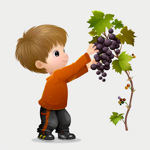

The image shows an animated character, a young boy with blonde hair, holding a bunch of grapes in his hands. He appears to be looking at the grapes with a surprised or curious expression. The boy is wearing a red shirt, and the background is plain white, which puts the focus on the character and the grapes. 


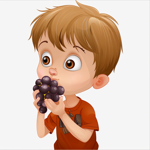

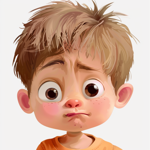

The image shows a stylized, cartoon-like illustration of a young boy with a surprised or shocked expression. He has blonde hair and is wearing an orange shirt. The artwork is detailed and colorful, with a focus on the boy's facial expression and the texture of his hair. 


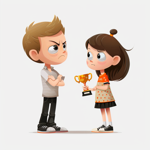

The image shows two animated characters, a boy and a girl, standing next to each other. The boy has a frown on his face and is holding his arms crossed, while the girl is holding a trophy and appears to be upset or disappointed. They seem to be in a competition or contest, as suggested by the trophy. The style of the animation is cartoonish and colorful. 


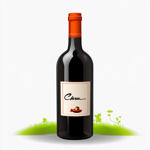

The image shows a bottle of wine with a label that reads "Château" followed by a name that is not fully visible. The label also features a graphic of a bunch of grapes and a green plant, which are common elements on wine labels to indicate the type of wine and its origin. The bottle is placed on a grassy surface, suggesting a natural or rural setting. The overall design is simple and elegant, typical of wine packaging. 


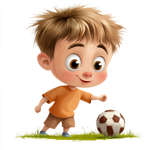

The image shows a cartoon illustration of a young boy with a surprised or excited expression. He has short, spiky hair and is wearing a short-sleeved orange shirt and brown shorts. The boy is standing on grass and appears to be reaching out to a soccer ball that is on the ground in front of him. The style of the illustration is playful and colorful, typical of children's book illustrations. 
expected image: 


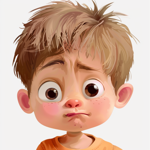

In [290]:
dataB_train = only_train(dataB)
print_item(9,dataB_train)


Ansatz: 
a) sequence caption vergleichen mit gpt data (BERT + SBERT)
b) image captions similarity to sequence captions


In [291]:
def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


def compare(emb,emb0,emb1):
    sim0 = cosine_similarity(emb,emb0)
    sim1 = cosine_similarity(emb,emb1)
    if sim0 > sim1:
        return 0
    else:
        return 1

def binary2values(list,val0,val1):
    final = []
    for element in list:
        if element == 1:
            final.append(val1)
        else:
            final.append(val0)
    return final


## Predict image

### compare sequence captions with image captions

#### choose by maximal similarity sum 

In [292]:
images = ["image1", "image2", "image3", "image4"]
sequence_captions = ['sequence_caption1', 'sequence_caption2']

# compare image captions to sequence captions
def compare_image_to_sequence(current,embedding):
    sims = []
    for image in images:
        seq_sim = []
        for seq in sequence_captions:
            seq_sim.append(cosine_similarity(current[seq+ "_embedding_" + embedding], current[image+ "_caption_embedding_" + embedding]))
        sims.append(seq_sim)
    return sims

In [293]:

# decide by maximal sum of similarities

dataB["pred_image_sbert"] = dataB.apply(lambda x:  
                                        np.argmax([sum(i) for i in compare_image_to_sequence(x,"sbert")]) + 1, 
                                        axis = 1)
dataB["pred_image_sbert"] = dataB.apply(lambda x: x["image" + str(x["pred_image_sbert"]) + "_name"], axis= 1)

In [294]:
from sklearn.metrics import accuracy_score

dataB_train = only_train(dataB)
print("accuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum)", str(accuracy_score(dataB_train["expected_item"], dataB_train["pred_image_sbert"])
))

f = open('results_subtaskB.txt', 'a')
f.write("\n" + "accuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum) ")
f.write("\n" + str(accuracy_score(dataB_train["expected_item"], dataB_train["pred_image_sbert"])))
f.close()


accuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum) 0.6


In [295]:
dataB["pred_image_meanLast4"] = dataB.apply(lambda x:  
                                        np.argmax([sum(i) for i in compare_image_to_sequence(x,"meanLast4")]) + 1, 
                                        axis = 1)
dataB["pred_image_meanLast4"] = dataB.apply(lambda x: x["image" + str(x["pred_image_meanLast4"]) + "_name"], axis= 1)

In [296]:
dataB_train = only_train(dataB)
print("accuracy score (comparison sequence captions and image caption, embedding: BERT_meanLast4, method: max sum)", 
      str(accuracy_score(dataB_train["expected_item"], dataB_train["pred_image_meanLast4"])
))

f = open('results_subtaskB.txt', 'a')
f.write("\naccuracy score (comparison sequence captions and image caption, embedding: BERT_meanLast4, method: max sum) \n" + 
        str(accuracy_score(dataB_train["expected_item"], dataB_train["pred_image_meanLast4"])))
f.close()


accuracy score (comparison sequence captions and image caption, embedding: BERT_meanLast4, method: max sum) 0.55


In [297]:
dataB["pred_image_lastCLS"] = dataB.apply(lambda x:  
                                        np.argmax([sum(i) for i in compare_image_to_sequence(x,"lastCLS")]) + 1, 
                                        axis = 1)
dataB["pred_image_lastCLS"] = dataB.apply(lambda x: x["image" + str(x["pred_image_lastCLS"]) + "_name"], axis= 1)

In [298]:
dataB_train = only_train(dataB)
print("accuracy score (comparison sequence captions and image caption, embedding: BERT_lastCLS, method: max sum)", 
      str(accuracy_score(dataB_train["expected_item"], dataB_train["pred_image_lastCLS"])
))

f = open('results_subtaskB.txt', 'a')
f.write("\naccuracy score (comparison sequence captions and image caption, embedding: BERT_lastCLS, method: max sum) \n" +
      str(accuracy_score(dataB_train["expected_item"], dataB_train["pred_image_lastCLS"])
))
f.close()

accuracy score (comparison sequence captions and image caption, embedding: BERT_lastCLS, method: max sum) 0.5


#### choose by maximum similarity 

In [299]:
# decide by maximum of similarity
dataB["pred_image_sbert"] = dataB.apply(lambda x:  
                                        np.argmax([max(i) for i in compare_image_to_sequence(x,"sbert")]) + 1, 
                                        axis = 1)
dataB["pred_image_sbert"] = dataB.apply(lambda x: x["image" + str(x["pred_image_sbert"]) + "_name"], axis= 1)

In [300]:
from sklearn.metrics import accuracy_score

dataB_train = only_train(dataB)
print("\naccuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum)", str(accuracy_score(dataB_train["expected_item"], dataB_train["pred_image_sbert"])
))

f = open('results_subtaskB.txt', 'a')
f.write("\naccuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum) \n" + 
        str(accuracy_score(dataB_train["expected_item"], dataB_train["pred_image_sbert"])
))
f.close()


accuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum) 0.65


## Predict idiomatic/literal

### predict by comparison of sequence caption with gpt sentence/meaning/image

In [301]:
sequence_captions = ['sequence_caption1', 'sequence_caption2']
bin_types = ["literal", "idiomatic"]
sent_types = ["meaning", "sentence", "image"]                        

def compare_sequence_to_gpt(current, embedding):
    sim = {}
    for sent in sent_types:
        sim_sent = []
        for bin in bin_types:
            sim_bin = []
            for seq in sequence_captions:
                sim_bin.append(
                    cosine_similarity(current["gpt_" + bin + "_" + sent +  "_embedding_" + embedding], 
                                      current[seq+ "_embedding_" + embedding]))
            sim_sent.append(sim_bin)
        sim[sent] = sim_sent
    return sim



In [302]:
for sent in sent_types:
    dataB["pred_binary_from_gpt_" + sent] = dataB.apply(
        lambda x:  np.argmax([sum(i) for i in compare_sequence_to_gpt(x,"sbert")[sent]]), axis=1)
    dataB["pred_binary_from_gpt_" + sent] = dataB["pred_binary_from_gpt_" + sent].replace([0,1],[ "literal",  "idiomatic"])
    

In [303]:
dataB_train = only_train(dataB)

f = open('results_subtaskB.txt', 'a')
for sent in sent_types:
    print("accuracy score (predict idiomaticity, compare sequence to gpt_" + sent + ", embedding: sbert, method: max sum)", 
          str(accuracy_score(dataB_train["pred_binary_from_gpt_" + sent], dataB_train["sentence_type"])
    ))
    f.write("\naccuracy score (predict idiomaticity, compare sequence to gpt_" + sent + ", embedding: sbert, method: max sum) \n" + 
          str(accuracy_score(dataB_train["pred_binary_from_gpt_" + sent], dataB_train["sentence_type"])
    ))
f.close()

accuracy score (predict idiomaticity, compare sequence to gpt_meaning, embedding: sbert, method: max sum) 0.7
accuracy score (predict idiomaticity, compare sequence to gpt_sentence, embedding: sbert, method: max sum) 0.6
accuracy score (predict idiomaticity, compare sequence to gpt_image, embedding: sbert, method: max sum) 1.0


In [304]:
# evaluate also for cheated data
dataB_filtered = dataB[dataB['sentence_type'].notnull()]
print("[including extended data]")
f = open('results_subtaskB.txt', 'a')
f.write("\n[including extended data]")
for sent in sent_types:
    print("accuracy score (predict idiomaticity, compare sequence to gpt_" + sent + ", embedding: sbert, method: max sum)", 
          str(accuracy_score(dataB_filtered["pred_binary_from_gpt_" + sent], dataB_filtered["sentence_type"])
    ))
    f.write("\naccuracy score (predict idiomaticity, compare sequence to gpt_" + sent + ", embedding: sbert, method: max sum) \n" + 
          str(accuracy_score(dataB_filtered["pred_binary_from_gpt_" + sent], dataB_filtered["sentence_type"])
    ))
f.close()

[including extended data]
accuracy score (predict idiomaticity, compare sequence to gpt_meaning, embedding: sbert, method: max sum) 0.65
accuracy score (predict idiomaticity, compare sequence to gpt_sentence, embedding: sbert, method: max sum) 0.75
accuracy score (predict idiomaticity, compare sequence to gpt_image, embedding: sbert, method: max sum) 0.9


In [305]:
for sent in sent_types:
    dataB["pred_binary_from_gpt_all"] = dataB.apply(
        lambda x:  np.argmax([sum([sum(i[0]) for i in compare_sequence_to_gpt(x,"sbert").values()]), 
                              sum([sum(i[1]) for i in compare_sequence_to_gpt(x,"sbert").values()])]), axis=1)
    dataB["pred_binary_from_gpt_all"] = dataB["pred_binary_from_gpt_all"].replace([0,1],[ "literal",  "idiomatic"])
    

In [306]:
dataB_train = only_train(dataB)
dataB_filtered = dataB[dataB['sentence_type'].notnull()]

print("accuracy score (predict idiomaticity, compare sequence to all gpt data, embedding: sbert, method: max sum)", 
      str(accuracy_score(dataB_train["pred_binary_from_gpt_all"], dataB_train["sentence_type"])))
print("[including extended data]", 
      str(accuracy_score(dataB_filtered["pred_binary_from_gpt_all"], dataB_filtered["sentence_type"])))

f = open('results_subtaskB.txt', 'a')
f.write("\naccuracy score (predict idiomaticity, compare sequence to all gpt data, embedding: sbert, method: max sum) \n" + 
      str(accuracy_score(dataB_train["pred_binary_from_gpt_all"], dataB_train["sentence_type"])))
f.write("\n[including extended data] \n" +
      str(accuracy_score(dataB_filtered["pred_binary_from_gpt_all"], dataB_filtered["sentence_type"])))
f.write("\n=====================================================================\n")
f.close()



accuracy score (predict idiomaticity, compare sequence to all gpt data, embedding: sbert, method: max sum) 0.95
[including extended data] 0.875


In [307]:
# max statt sum
for sent in sent_types:
    dataB["pred_binary_from_gpt_all"] = dataB.apply(
        lambda x:  np.argmax([max([sum(i[0]) for i in compare_sequence_to_gpt(x,"sbert").values()]), 
                              max([sum(i[1]) for i in compare_sequence_to_gpt(x,"sbert").values()])]), axis=1)
    dataB["pred_binary_from_gpt_all"] = dataB["pred_binary_from_gpt_all"].replace([0,1],[ "literal",  "idiomatic"])
    

In [308]:
x = dataB.iloc[0]
compare_sequence_to_gpt(x,"sbert")

{'meaning': [[0.10308089, 0.101322025], [0.11582688, 0.1676422]],
 'sentence': [[0.13983656, 0.09417425], [0.09799909, 0.11707244]],
 'image': [[0.414702, 0.32476348], [0.41457435, 0.45902064]]}

In [309]:
dataB_train = only_train(dataB)
dataB_filtered = dataB[dataB['sentence_type'].notnull()]

print("accuracy score (predict idiomaticity, compare sequence to all gpt data, embedding: sbert, method: max max)", 
      str(accuracy_score(dataB_train["pred_binary_from_gpt_all"], dataB_train["sentence_type"])))
print("[including extended data]", 
      str(accuracy_score(dataB_filtered["pred_binary_from_gpt_all"], dataB_filtered["sentence_type"])))

f = open('results_subtaskB.txt', 'a')
f.write("\naccuracy score (predict idiomaticity, compare sequence to all gpt data, embedding: sbert, method: max max) \n" + 
      str(accuracy_score(dataB_train["pred_binary_from_gpt_all"], dataB_train["sentence_type"])))
f.write("\n[including extended data] \n" +
      str(accuracy_score(dataB_filtered["pred_binary_from_gpt_all"], dataB_filtered["sentence_type"])))
f.write("\n=====================================================================\n")
f.close()



accuracy score (predict idiomaticity, compare sequence to all gpt data, embedding: sbert, method: max max) 1.0
[including extended data] 0.9


In [310]:
from sklearn.metrics import classification_report

print(classification_report(dataB_train["pred_binary_from_gpt_all"], dataB_train["sentence_type"]))
print(classification_report(dataB_filtered["pred_binary_from_gpt_all"], dataB_filtered["sentence_type"]))

              precision    recall  f1-score   support

   idiomatic       1.00      1.00      1.00        13
     literal       1.00      1.00      1.00         7

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

              precision    recall  f1-score   support

   idiomatic       0.85      0.94      0.89        18
     literal       0.95      0.86      0.90        22

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



In [323]:
x = dataB.iloc[0]
compare_sequence_to_gpt(x,"sbert")
# [literal [seq caption 1, seq caption 2], idiomatic [seq caption 1, seq caption 2]]

{'meaning': [[0.10308089, 0.101322025], [0.11582688, 0.1676422]],
 'sentence': [[0.13983656, 0.09417425], [0.09799909, 0.11707244]],
 'image': [[0.414702, 0.32476348], [0.41457435, 0.45902064]]}

In [333]:
# with difference (compute differences between literal and idiomatic similarity values and add the differences. If sum>0 => literal)
dataB["pred_difference_from_gpt_all"] = dataB.apply(
        lambda x:  [sum(i[0]) - sum(i[1]) for i in compare_sequence_to_gpt(x,"sbert").values()], axis=1)
dataB["pred_difference_from_gpt_all"][0]

[-0.07906617224216461, 0.018939286470413208, -0.13412952423095703]

In [334]:
for i in range(len(dataB)):
    old = dataB["pred_difference_from_gpt_all"][i]
    new = sum(old)
    if new > 0:
        new = "literal"
    else:
        new = "idiomatic"
    dataB["pred_difference_from_gpt_all"][i] = new


In [337]:
dataB_train = only_train(dataB)
print(classification_report(dataB_train["pred_difference_from_gpt_all"], dataB_train["sentence_type"]))
dataB_filtered = dataB[dataB['sentence_type'].notnull()]
print(classification_report(dataB_filtered["pred_difference_from_gpt_all"], dataB_filtered["sentence_type"]))


              precision    recall  f1-score   support

   idiomatic       0.92      1.00      0.96        12
     literal       1.00      0.88      0.93         8

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20

              precision    recall  f1-score   support

   idiomatic       0.80      0.94      0.86        17
     literal       0.95      0.83      0.88        23

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.89      0.88      0.88        40



### output file

In [320]:
from zipfile import ZipFile
def make_submission(data, binary_column, image_column, subset):
    subset_data = only_subset(data,subset)
    submission_df = pd.DataFrame()
    submission_df["compound"] = subset_data["compound"]
    submission_df["subset"] = subset_data["subset"]
    submission_df["sentence_type"] = subset_data[binary_column]
    submission_df["expected_item"] = subset_data[image_column]
    submission_df.to_csv("submission_EN.tsv", sep="\t", index=False)
    ZipFile('submission_EN.zip', 'w').write('submission_EN.tsv')
    print("File zipped and saved as submission_EN.zip")
    return submission_df


In [338]:
#test = make_submission(dataB, "pred_binary_from_gpt_all","pred_image_sbert", "Dev")
test = make_submission(dataB, "pred_difference_from_gpt_all","pred_image_sbert", "Test")

File zipped and saved as submission_EN.zip


In [322]:
dataB["subset"].value_counts()

Extended Evaluation    30
Sample                 10
Train                  10
Dev                     5
Test                    5
Name: subset, dtype: int64

Output rsults_subtaskB einmal mit und einmal ohne Preprocessing:


~~~ 
=====================================================================
_preprocessed_
accuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum) 
0.65
accuracy score (comparison sequence captions and image caption, embedding: BERT_meanLast4, method: max sum) 
0.45
accuracy score (comparison sequence captions and image caption, embedding: BERT_lastCLS, method: max sum) 
0.25
accuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum) 
0.6
accuracy score (predict idiomaticity, compare sequence to gpt_meaning, embedding: sbert, method: max sum) 
0.75
accuracy score (predict idiomaticity, compare sequence to gpt_sentence, embedding: sbert, method: max sum) 
0.75
accuracy score (predict idiomaticity, compare sequence to gpt_image, embedding: sbert, method: max sum) 
0.8
[including extended data]
accuracy score (predict idiomaticity, compare sequence to gpt_meaning, embedding: sbert, method: max sum) 
0.675
accuracy score (predict idiomaticity, compare sequence to gpt_sentence, embedding: sbert, method: max sum) 
0.8
accuracy score (predict idiomaticity, compare sequence to gpt_image, embedding: sbert, method: max sum) 
0.8
accuracy score (predict idiomaticity, compare sequence to all gpt data, embedding: sbert, method: max sum) 
0.95
[including extended data] 
0.925
=====================================================================

=====================================================================
_
accuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum) 
0.6
accuracy score (comparison sequence captions and image caption, embedding: BERT_meanLast4, method: max sum) 
0.55
accuracy score (comparison sequence captions and image caption, embedding: BERT_lastCLS, method: max sum) 
0.5
accuracy score (comparison sequence captions and image caption, embedding: sbert, method: max sum) 
0.65
accuracy score (predict idiomaticity, compare sequence to gpt_meaning, embedding: sbert, method: max sum) 
0.7
accuracy score (predict idiomaticity, compare sequence to gpt_sentence, embedding: sbert, method: max sum) 
0.6
accuracy score (predict idiomaticity, compare sequence to gpt_image, embedding: sbert, method: max sum) 
1.0
[including extended data]
accuracy score (predict idiomaticity, compare sequence to gpt_meaning, embedding: sbert, method: max sum) 
0.65
accuracy score (predict idiomaticity, compare sequence to gpt_sentence, embedding: sbert, method: max sum) 
0.75
accuracy score (predict idiomaticity, compare sequence to gpt_image, embedding: sbert, method: max sum) 
0.9
accuracy score (predict idiomaticity, compare sequence to all gpt data, embedding: sbert, method: max sum) 
0.95
[including extended data] 
0.875
=====================================================================
~~~
